# PCA Analysis

Purpose: Exploring the effectiveness of PCA for compressing patient scans. A compression technique is required, as the scans in their original size are too big and will take too long to be analyzed by neural networks.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob
import re
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from time import time
import math

In [2]:
# constants

data = '/kaggle/dev/data-science-bowl-2017-data/'
stage1 = '/kaggle/dev/data-science-bowl-2017-data/stage1/'
sample_images = '/kaggle/dev/data-science-bowl-2017-data/sample_images/'
labels = '/kaggle/dev/data-science-bowl-2017-data/stage1_labels.csv'
stage1_processed = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
stage1_features = '/kaggle/dev/data-science-bowl-2017-data/stage1_features_mx/'
stage1_submission = '/kaggle/dev/data-science-bowl-2017-data/stage1_sample_submission.csv'
naive_submission = '/kaggle/dev/jovan/data-science-bowl-2017/data-science-bowl-2017/submissions/naive_submission.csv'

## Setup

In [43]:
sample_ids = []

for d in os.listdir(sample_images):
    sample_ids.append(d)
    print("Patient '{}' has {} scans".format(d, len(os.listdir(sample_images + d))))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(stage1)), 
                                                      len(glob.glob(stage1 + '*/*.dcm'))))

Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0d2fcf787026fece4e57be167d079383' has 126 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0d941a3ad6c889ac451caf89c46cb92a' has 177 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0c0de3749d4fe175b7a5098b060982a1' has 123 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0de72529c30fe642bc60dcb75c87f6bd' has 113 scans
Patient '0ddeb08e9c97227853422bd71a2a695e' has 171 scans
Patient '0a099f2549429d29b32f34

In [44]:
print("Analysis will be done on:")
num_patients = 20 # number of patients to analyze
segmented_lungs_fill = []
segmented_lungs = []

for folder in glob.glob(stage1_processed + 'scan_segmented_lungs_fill_*'):
    m = re.match(r'scan_segmented_lungs_fill_([a-f0-9].*).npy', os.path.basename(folder))
    if(m.group(1) in sample_ids[0:num_patients]):
        x = np.load(stage1_processed + m.group(0))
        y = np.load(stage1_processed + "scan_segmented_lungs_" + str(m.group(1)) + ".npy" )
        segmented_lungs_fill.append(x)
        segmented_lungs.append(y)
        print('Patient {}: array shape: {}'.format(m.group(1), x.shape))

Analysis will be done on:
Patient 0a0c32c9e08cc2ea76a71649de56be6d: array shape: (332, 340, 340)
Patient 0bd0e3056cbf23a1cb7f0f0b18446068: array shape: (350, 340, 340)
Patient 0c0de3749d4fe175b7a5098b060982a1: array shape: (308, 355, 355)
Patient 0acbebb8d463b4b9ca88cf38431aac69: array shape: (365, 279, 279)
Patient 0c9d8314f9c69840e25febabb1229fa4: array shape: (398, 309, 309)
Patient 0de72529c30fe642bc60dcb75c87f6bd: array shape: (282, 308, 308)
Patient 0d19f1c627df49eb223771c28548350e: array shape: (366, 370, 370)
Patient 0d2fcf787026fece4e57be167d079383: array shape: (315, 310, 310)
Patient 0c60f4b87afcb3e2dfa65abbbf3ef2f9: array shape: (272, 330, 330)
Patient 00cba091fa4ad62cc3200a657aeb957e: array shape: (335, 306, 306)
Patient 0c37613214faddf8701ca41e6d43f56e: array shape: (328, 360, 360)
Patient 0a38e7597ca26f9374f8ea2770ba870d: array shape: (275, 320, 320)
Patient 0d941a3ad6c889ac451caf89c46cb92a: array shape: (354, 259, 259)
Patient 0c98fcb55e3f36d0c2b6507f62f4c5f1: array sha

Let's plot one patient (patient[0]) to see what the data looks like

In [10]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
#     ax.invert_zaxis()


    plt.show()

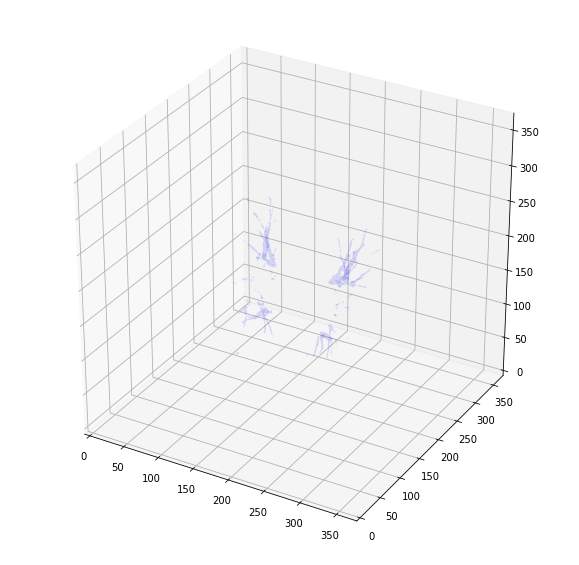

In [62]:
plot_3d(segmented_lungs_fill[6], 0)

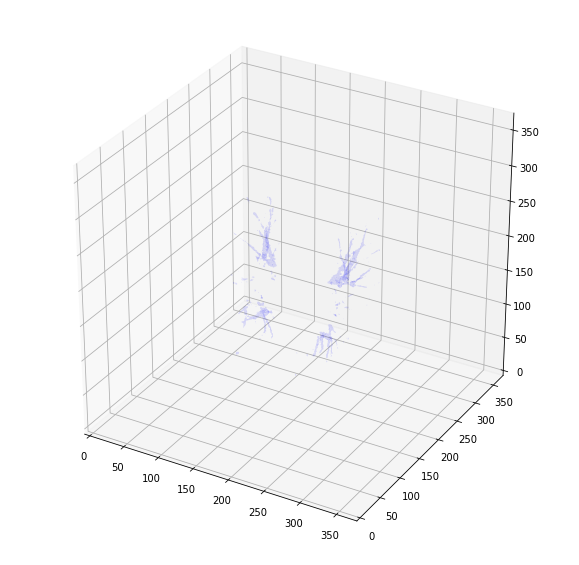

In [63]:
plot_3d(segmented_lungs_fill[6] - segmented_lungs[6], 0)

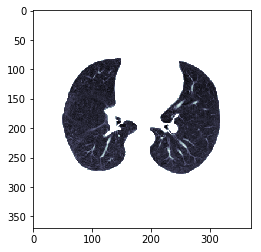

206


In [95]:
def plot_2d(im):
    # Show some slice in the middle
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()

# Show some slice in the middle
random_slice_index = int(np.random.random() * len(segmented_lungs_fill[6]))
plot_2d(segmented_lungs_fill[6][random_slice_index])
print(random_slice_index)

In [53]:
lungs = []
for i in range(0, num_patients):
    temp = segmented_lungs_fill[i] - segmented_lungs[i]
    lungs.append(temp)

## PCA

In [54]:
# Flatenning images to prep for PCA
lungs_flatten = []
for i in range(0, num_patients):

    temp = lungs[i].reshape(lungs[i].shape[0], lungs[i].shape[1]*lungs[i].shape[2])
    lungs_flatten.append(temp)
    print("Patient {}: original size {} -> flattened size: {}".format(i, lungs[i].shape, lungs_flatten[i].shape))

Patient 0: original size (332, 340, 340) -> flattened size: (332, 115600)
Patient 1: original size (350, 340, 340) -> flattened size: (350, 115600)
Patient 2: original size (308, 355, 355) -> flattened size: (308, 126025)
Patient 3: original size (365, 279, 279) -> flattened size: (365, 77841)
Patient 4: original size (398, 309, 309) -> flattened size: (398, 95481)
Patient 5: original size (282, 308, 308) -> flattened size: (282, 94864)
Patient 6: original size (366, 370, 370) -> flattened size: (366, 136900)
Patient 7: original size (315, 310, 310) -> flattened size: (315, 96100)
Patient 8: original size (272, 330, 330) -> flattened size: (272, 108900)
Patient 9: original size (335, 306, 306) -> flattened size: (335, 93636)
Patient 10: original size (328, 360, 360) -> flattened size: (328, 129600)
Patient 11: original size (275, 320, 320) -> flattened size: (275, 102400)
Patient 12: original size (354, 259, 259) -> flattened size: (354, 67081)
Patient 13: original size (360, 350, 350)

In [55]:
def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

def zero_center(image):
    PIXEL_MEAN = 0.619758226836
    image = image - PIXEL_MEAN
    return image

In [56]:
def PCA_transform(patient_data, components):
    if(components >= patient_data.shape[0]):
        n_components = patient_data.shape[0]
    else:
        n_components = components
    print("n_componenets: " + str(n_components))
    h = int(math.sqrt(patient_data.shape[1]))
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(patient_data)
    patient_data_pca = pca.transform(patient_data)
    eigenvectors = pca.components_.reshape((n_components, h, h))
    explained_variance_ratio = pca.explained_variance_ratio_
    return patient_data_pca, eigenvectors, explained_variance_ratio

In [57]:
def analyze_pca_varience(explained_variance_ratio, treshold):
    for i in explained_variance_ratio:
        if i <= treshold:
            return int(np.where(explained_variance_ratio <= (i))[0][0]) ## returning only the 0th element

In [58]:
n_components = 100000
treshold = 0.0001
patient_data_pca = []
eigenvectors = []
explained_variance_ratio = []
min_eigenvector= []
t0 = time()
for j in range(0, 3):
    t1 = time()
    lungs_flatten[j] = normalize(lungs_flatten[j])
    lungs_flatten[j] = zero_center(lungs_flatten[j])
    print("shape: " + str(lungs_flatten[j].shape))
    w, x, y = PCA_transform(lungs_flatten[j],n_components)
    z = analyze_pca_varience(y, treshold)
    patient_data_pca.append(w)
    eigenvectors.append(x)
    explained_variance_ratio.append(y)
    min_eigenvector.append(z)
    print("interation "+ str(j) + ", done in %0.3fs" % (time() - t1))
print("---")
print("total computation done in %0.3fs" % (time() - t0))

shape: (332, 115600)
n_componenets: 332
interation 0, done in 14.388s
shape: (350, 115600)
n_componenets: 350
interation 1, done in 15.554s
shape: (308, 126025)
n_componenets: 308
interation 2, done in 16.604s
---
total computation done in 46.548s


In [59]:
val = 2
print(lungs_flatten[val].shape)
print(patient_data_pca[val].shape)
print(eigenvectors[val].shape)

(308, 126025)
(308, 308)
(308, 355, 355)


Let's see what the eigenvectors look like for a one patient (patient[0])

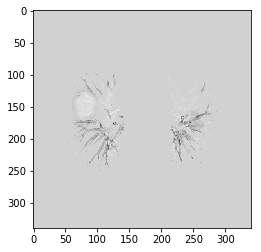

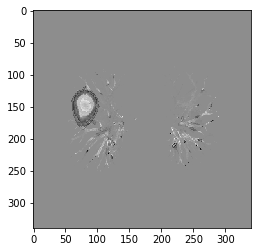

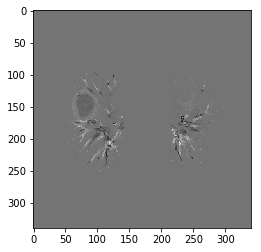

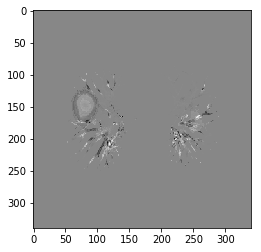

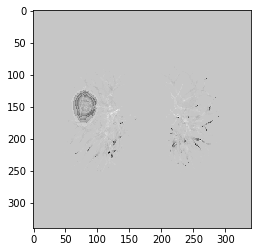

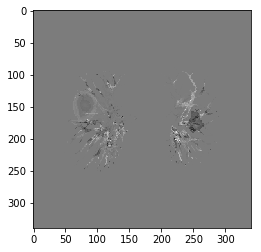

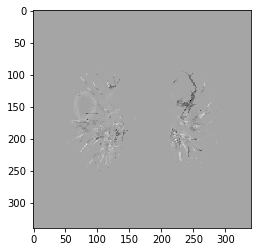

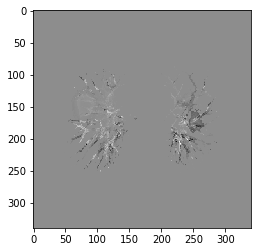

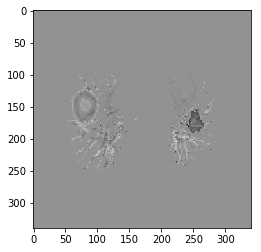

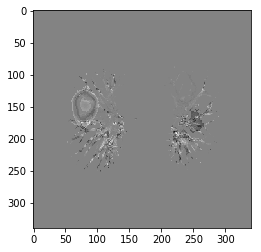

In [60]:
patient_num = 0
for i in range(0,10):
    plt.imshow(eigenvectors[patient_num][i].reshape(eigenvectors[patient_num].shape[1], 
                                                   eigenvectors[patient_num].shape[2]), cmap=plt.cm.gray)
    plt.show()

Analyzing the minimum number of eigenvectors where varience <= treshold:

In [191]:

for i in min_eigenvector:
    print(i)

369
208
193
206
241
214
172
305
226
238
248
242
206
25
201
217
200
229
215
242


Analyzing run time for n_components for sample size of 10

In [500]:
n_components = 10
runs = 5
t0 = time()
runtimes = {}

for i in range(95, 105):
    for j in range(0, runs):
        t1 = time()
        w, x, y = PCA_transform(segmented_lungs_fill_flatten[j],n_components)

    print("---")
    print("total computation for n_components = " + str(i) + ", done in %0.3fs" % (time() - t0))
    runtimes[i] = (time() - t0)
    

---
total computation for n_components = 95, done in 14.345s
---
total computation for n_components = 96, done in 28.663s
---
total computation for n_components = 97, done in 43.051s
---
total computation for n_components = 98, done in 57.324s
---
total computation for n_components = 99, done in 71.548s
---
total computation for n_components = 100, done in 85.880s
---
total computation for n_components = 101, done in 100.165s
---
total computation for n_components = 102, done in 114.413s
---
total computation for n_components = 103, done in 128.650s
---
total computation for n_components = 104, done in 142.987s


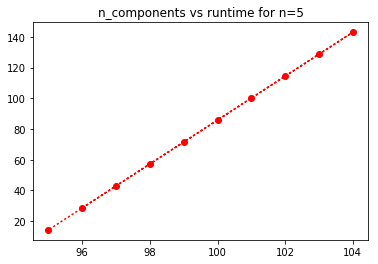

In [503]:
plt.plot(list(runtimes.keys()), list(runtimes.values()), 'ro:')
plt.title('n_components vs runtime for n=5')
plt.show()